## Costly conversion data challenge

### Aims: 
- Understand some of the main drivers for customer conversion 
- Assess the cost and outcome of the experiment 
- Could the experiment have been done on a shorter timescale?
- What could have been improved?

In [74]:
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
plt.style.use('ggplot')

In [26]:
testdf = pd.read_csv('test_results.csv') #contains control and test 
userdf = pd.read_csv('user_table.csv') #contains information about the user

In [27]:
testdf.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted
0,0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39.0,0
1,1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39.0,0
2,2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39.0,0
3,3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59.0,0
4,4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39.0,0


In [28]:
userdf.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


There is one row per first time user visit, so each visit is unique

In [29]:
len(testdf['user_id'].unique()) - len(testdf)

0

In [30]:
testdf.dtypes

Unnamed: 0            int64
user_id               int64
timestamp            object
source               object
device               object
operative_system     object
test                  int64
price               float64
converted             int64
dtype: object

In [31]:
userdf.dtypes

user_id      int64
city        object
country     object
lat        float64
long       float64
dtype: object

Merge the tables

In [42]:
merged_table = pd.merge(testdf,userdf,on='user_id',how='outer')

Check proportion of NaNs

In [43]:
merged_table.isna().sum()/len(merged_table)

Unnamed: 0          0.000000
user_id             0.000000
timestamp           0.001054
source              0.000985
device              0.000000
operative_system    0.064201
test                0.000000
price               0.000000
converted           0.000000
city                0.130000
country             0.130000
lat                 0.130000
long                0.130000
dtype: float64

Check the unique values in the operating system and source columns

In [44]:
merged_table['operative_system'].unique()

array(['iOS', 'android', 'mac', 'windows', nan, 'i0S', 'wnddows',
       'anroid', 'apple'], dtype=object)

In [45]:
merged_table['source'].unique()

array(['ads_facebook', 'seo-google', 'ads-bing', 'direct_traffic',
       'ads-google', 'seo_facebook', 'friend_referral', 'ads_other',
       'ads-yahoo', 'seo-yahoo', 'seo-bing', 'seo-other', nan],
      dtype=object)

In [46]:
#Functions to remove strange entries in the columns we want to use

def convert_datetime(val):
    
    try:
        val = pd.to_datetime(val)
    except:
        val = np.nan
        
    return val

def remove_bad_prices(val):
    
    if val in [59.0,39.0]:
        return val
    else:
        return np.nan

def remove_bad_os(val):
    
    if val in ['iOS','i0S']:
        return 'ios'
    elif val in ['windows','wnddows']:
        return 'windows'
    elif val in ['anroid','android']:
        return 'android'
    elif val in ['mac','apple']:
        return 'mac'
    else:
        return np.nan
    
def remove_bad_source(val):
    
    if val in ['ads_facebook', 'seo-google', 'ads-bing', 'direct_traffic',
               'ads-google', 'seo_facebook', 'friend_referral', 'ads_other',
               'ads-yahoo', 'seo-yahoo', 'seo-bing', 'seo-other']:
        return val
    else:
        return np.nan

In [47]:
merged_table['timestamp_mod'] = merged_table['timestamp'].apply(convert_datetime)

In [48]:
merged_table['price'] = merged_table['price'].apply(remove_bad_prices)
merged_table['operative_system'] = merged_table['operative_system'].apply(remove_bad_os)
merged_table['source'] = merged_table['source'].apply(remove_bad_source)

In [49]:
merged_table.isna().sum()/len(merged_table)

Unnamed: 0          0.000000
user_id             0.000000
timestamp           0.001054
source              0.000985
device              0.000000
operative_system    0.064201
test                0.000000
price               0.009703
converted           0.000000
city                0.130000
country             0.130000
lat                 0.130000
long                0.130000
timestamp_mod       0.034391
dtype: float64

In [50]:
##Lets only consider users for which we have all the information
merged_table.dropna(inplace=True)

In [51]:
merged_table.isna().sum()/len(merged_table)

Unnamed: 0          0.0
user_id             0.0
timestamp           0.0
source              0.0
device              0.0
operative_system    0.0
test                0.0
price               0.0
converted           0.0
city                0.0
country             0.0
lat                 0.0
long                0.0
timestamp_mod       0.0
dtype: float64

### 1: What proportion of users who saw the two prices converted?

In [52]:
control = merged_table[merged_table['test']==0]
test = merged_table[merged_table['test']==1]

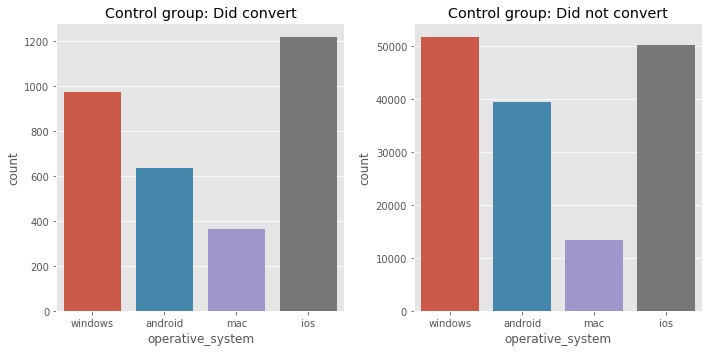

In [61]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.countplot(x='operative_system',data=control[control['converted']==1],order=['windows','android','mac','ios'],ax=ax1)
sns.countplot(x='operative_system',data=control[control['converted']==0],order=['windows','android','mac','ios'],ax=ax2)
ax1.set_title('Control group: Did convert')
ax2.set_title('Control group: Did not convert')
plt.tight_layout()
plt.savefig('Control_opsys.png',dpi=200)

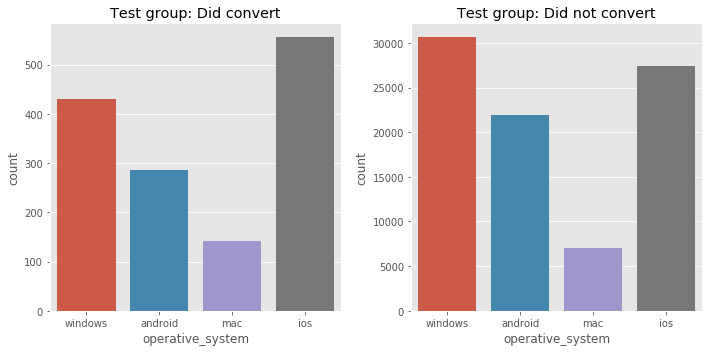

In [62]:
fig = plt.figure(figsize = (10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
sns.countplot(x='operative_system',data=test[test['converted']==1],order=['windows','android','mac','ios'],ax=ax1)
sns.countplot(x='operative_system',data=test[test['converted']==0],order=['windows','android','mac','ios'],ax=ax2)
ax1.set_title('Test group: Did convert')
ax2.set_title('Test group: Did not convert')
plt.tight_layout()
plt.savefig('Test_opsys.png',dpi=200)

### 2. What proportion of users from various sources converted

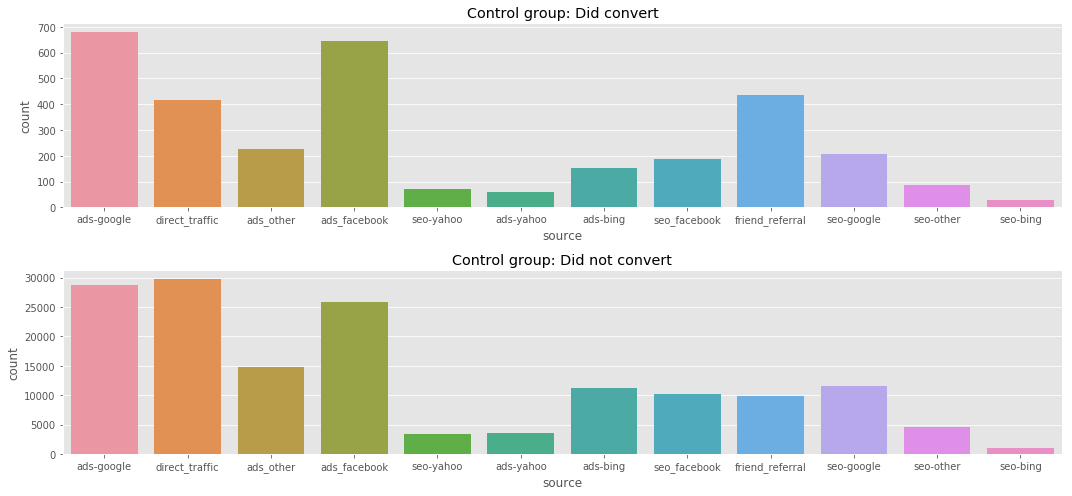

In [133]:
sources = list(test['source'].unique())
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.countplot(x='source',data=control[control['converted']==1],order=sources,ax=ax1)
sns.countplot(x='source',data=control[control['converted']==0],order=sources,ax=ax2)
ax1.set_title('Control group: Did convert')
ax2.set_title('Control group: Did not convert')
plt.tight_layout()
plt.savefig('Control_source.png',dpi=200)

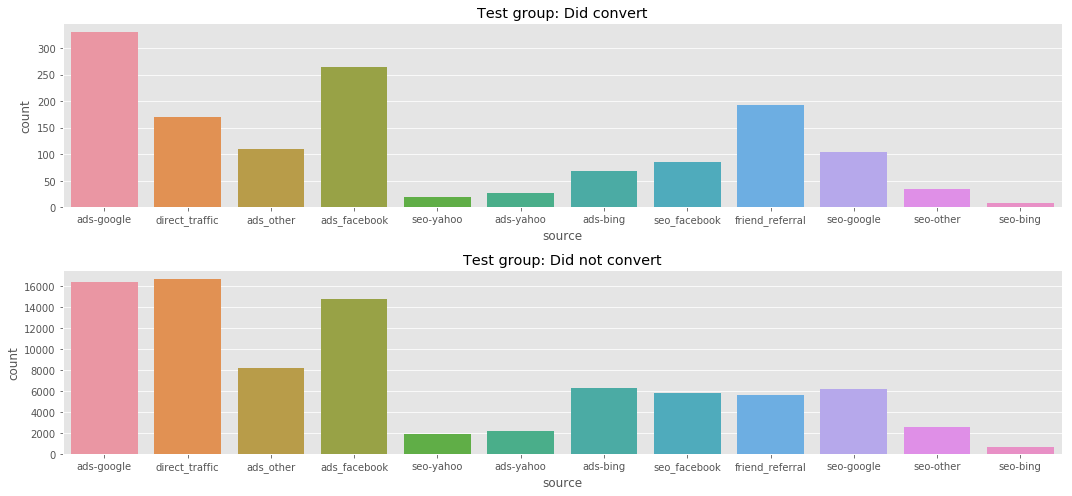

In [134]:
sources = list(test['source'].unique())
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
sns.countplot(x='source',data=test[test['converted']==1],order=sources,ax=ax1)
sns.countplot(x='source',data=test[test['converted']==0],order=sources,ax=ax2)
ax1.set_title('Test group: Did convert')
ax2.set_title('Test group: Did not convert')
plt.tight_layout()
plt.savefig('Test_source.png',dpi=200)

### Check that the length of the control and test datasets make sense

In [65]:
len(control)/(len(control)+len(test))

0.6408625113680655

In [66]:
len(test)/(len(control)+len(test))

0.3591374886319345

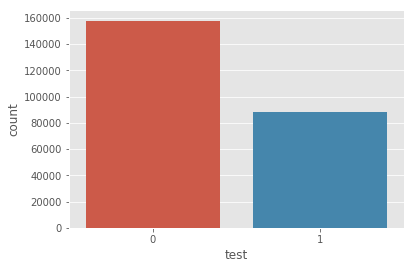

In [67]:
sns.countplot(x='test',data=merged_table)

### 3. What proportion of the two groups converted? What is mean value per visit in each case?  
We are just finding  mean of a population containing just ones and zeros.     
We can use a proportional z-test to see if the difference between sample means is significant.   

In [68]:
proportion_control_converted_value  = 39*len(control[control['converted']==1])/len(control)
proportion_test_converted_value  = 59*len(test[test['converted']==1])/len(test)

sum_control_revenue = control[control['converted']==1]['price'].sum()
sum_test_revenue = test[test['converted']==1]['price'].sum()

In [69]:
heights_control = [len(control[control['converted']==1])/len(control),len(control[control['converted']==0])/len(control)]
heights_test = [len(test[test['converted']==1])/len(test),len(test[test['converted']==0])/len(test)]

In [70]:
heights_control,heights_test

([0.02024111956514853, 0.9797588804348515],
 [0.015973863006884702, 0.9840261369931153])

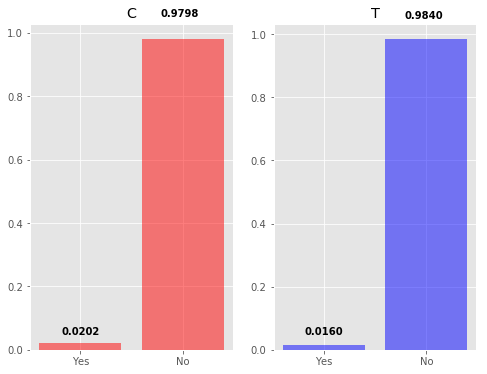

In [71]:
#Plot the proportion of users who converted in control and test groups
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.bar(x=['Yes','No'],height=heights_control,color='red',alpha=0.5)

for i, v in enumerate(heights_control):
    ax1.text(v-0.2, i + 0.05, '%.4f' %v, fontweight='bold')
    
ax2.bar(x=['Yes','No'],height=heights_test,color='blue',alpha=0.5)

for i, v in enumerate(heights_test):
    ax2.text(v-0.2, i + 0.05, '%.4f' %v, fontweight='bold')
    
ax1.set_title('C')
ax2.set_title('T')
plt.savefig('Conversion_rates.png',dpi=200)

In [72]:
proportion_control_converted_value, proportion_test_converted_value

(0.7894036630407927, 0.9424579174061973)

### 4. How much did the experiment cost?  
This is just the difference between the mean revenue per visit times the number of visits in the control
group

In [73]:
len(control)*(proportion_test_converted_value-proportion_control_converted_value)

24159.15488881603

### 5. Is this difference in proportions statistically significant? 

In [75]:
s1 = len(control[control['converted']==1]) #number of conversions in control
n1 = len(control['converted']) #total population in control

s2 = len(test[test['converted']==1]) #number of conversions in test
n2 = len(test['converted']) #total population in test

print(s1,n1,s2,n2)

#Do a z-test to determine the chance that the difference observed between the two populations was 
#done so by chance

zscore, pval = proportions_ztest([s1, s2], [n1, n2], alternative='two-sided')

3195 157847 1413 88457


In [76]:
zscore,pval

(7.498558595474347, 6.452340828997087e-14)

### How long should we have run the test for?

This low p value indicates that the results are statistically significant ... then the question becomes, how long should we have run the trial for?

To answer this question, we can divide the dataset into blocks of time, find the total proportions of converted and non-converted in each chunck and then run a z-test. Once the results become significant, we know that we can end the test

In [77]:
merged_table.sort_values(by='timestamp_mod',inplace=True)

In [91]:
#Define a function that allows us to extract each unique week

def extract_week(timestamp):
    
    return '%s-%s' %(timestamp.year,timestamp.week)

def extract_day(timestamp):
    
    return '%s-%s-%s' %(timestamp.year,timestamp.week,timestamp.day)


In [80]:
merged_table['YW'] = merged_table['timestamp_mod'].apply(extract_week)

In [81]:
merged_table.head()

,Unnamed: 0,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,timestamp_mod,YW
166052,166052,503836,2015-03-02 00:04:12,ads-google,web,windows,1,59.0,0,Plymouth,USA,45.02,-93.46,2015-03-02 00:04:12,2015-10
20240,20240,583796,2015-03-02 00:12:40,ads_facebook,web,windows,0,39.0,0,Jacksonville,USA,30.33,-81.66,2015-03-02 00:12:40,2015-10
278620,278620,632922,2015-03-02 00:16:25,ads-google,web,windows,0,39.0,0,Virginia Beach,USA,36.74,-76.04,2015-03-02 00:16:25,2015-10
206916,206916,813542,2015-03-02 00:18:46,direct_traffic,web,mac,0,39.0,0,North Port,USA,27.05,-82.19,2015-03-02 00:18:46,2015-10
271250,271250,866803,2015-03-02 00:18:46,direct_traffic,web,mac,0,39.0,0,North Port,USA,27.05,-82.19,2015-03-02 00:18:46,2015-10


### Plot the number of test and control users each week. This should hopefully be farily consistent

In [82]:
all_users_per_week = merged_table[['test','YW']].groupby('YW').count()

In [83]:
test_users_per_week = merged_table[['test','YW']].groupby('YW').sum()

In [84]:
control_users_per_week = merged_table[merged_table['test']==0][['test','YW']].groupby('YW').count()

In [85]:
df = pd.DataFrame({'all_users':all_users_per_week['test'],'test_users':test_users_per_week['test'],
                  'control_users':control_users_per_week['test']})

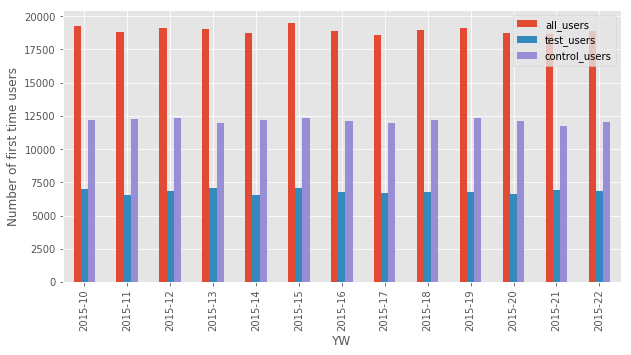

In [86]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
df.plot.bar(ax=ax1)
plt.ylabel('Number of first time users')
plt.savefig('Weekly_numbers.png',dpi=200)

### Now we want to assess the length of time for which we could have run the test 
To do this, we find the cumulative number of users in the test and control dataframes over each week.
At each stage, we determine the number of conversions and test for significance

In [88]:
def compare_week(timestamp,yr,wk):
    
    if (timestamp.year <= yr) and (timestamp.week <= wk):
        return 1
    else:
        return 0

## Cumulative numbers in test and control groups per week
weeks = list(pd.unique(merged_table['YW']))

total_weeks = []
total_converted_control = []
total_converted_test = []
total_control = []
total_test = []
pvalues = []

slicetable = merged_table.copy()

for week in weeks:
    
    timeparts = week.split('-')
    year = int(timeparts[0])
    week = int(timeparts[1])
    
    slicetable['compare_week'] = slicetable['timestamp_mod'].apply(compare_week,args=(year,week))
    
    #Get all the data within the period of interest
    inweek = slicetable[slicetable['compare_week']==1]
    
    #Split into contol and test dataframes
    control = inweek[inweek['test']==0]
    test = inweek[inweek['test']==1]
    
    #Get all the test users in that period
    test_users_in_period = len(test)
    #Get all the contol users in that period
    control_users_in_period = len(control)
    #Get the total number of users in that period
    all_users_in_period = len(inweek)
    
    #Get the proportions who converted in each group
    
    s1 = len(control[control['converted']==1])
    n1 = len(control['converted'])
    
    s2 = len(test[test['converted']==1])
    n2 = len(test['converted'])
    
    zscore, pval = proportions_ztest([s1, s2], [n1, n2], alternative='two-sided')
    
    total_weeks.append(all_users_in_period)
    total_converted_control.append(s1/n1)
    total_converted_test.append(s2/n2)
    total_control.append(n1)
    total_test.append(n2)
    pvalues.append(pval)
    
    #print(test_users_in_period,control_users_in_period,all_users_in_period,
    #      all_users_in_period-(test_users_in_period+control_users_in_period))
    print(zscore,pval)
    
    

1.9230840496194885 0.05446949516428314
1.5716002854406275 0.11604328023899829
2.0998017062260885 0.03574628810434961
2.436317454394807 0.014837656432151356
3.4620154750313685 0.0005361463266295379
4.4644127275038965 8.028866583835457e-06
5.337589073409841 9.419063309683673e-08
5.772365428468634 7.816636598396925e-09
6.662086879428318 2.6996634858605265e-11
6.990338059507853 2.7422466103191815e-12
7.3240353851284095 2.406231945707193e-13
7.5608294693972855 4.005070435262394e-14
7.498558595474347 6.452340828997087e-14


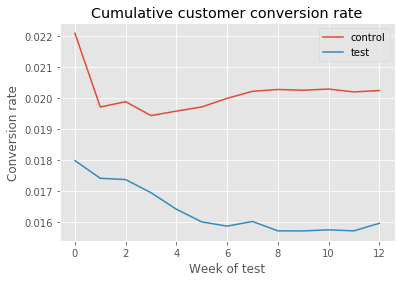

In [89]:
plt.plot(total_converted_control,label='control')
plt.plot(total_converted_test,label='test')
plt.legend(loc='best')
plt.xlabel('Week of test')
plt.ylabel('Conversion rate')
plt.title('Cumulative customer conversion rate')
plt.savefig("Cumulative_conversion_rate.png",dpi=200)

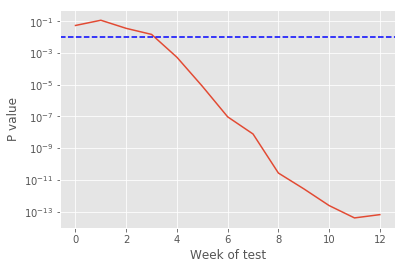

In [90]:
plt.semilogy(pvalues)
plt.axhline(0.01,color='blue',linestyle='--')
plt.xlabel('Week of test')
plt.ylabel('P value')
plt.savefig('Cumulative_p_value.png',dpi=200)

It looks like the cumulative conversion rate is fairly constant over time and that within about 4 weeks of running the experiment the p-value has dropped below 0.01, which suggests that the results become significant after this point

### How could the experiment be improved?

- Determine the cycicity in customer conversions and run for a maximum of two cycles  
- Do a more focussed test where different prices are shown to people on different platforms and who arrive from different sources: It might be possible that users who are referred by friends are willing to pay more, for example
- Ensure that the distribution of user locations in the control and test populations are equal

In [97]:
from scipy import signal

In [92]:
merged_table['YWD'] = merged_table['timestamp_mod'].apply(extract_day)

In [93]:
all_conversions_per_day = merged_table[['converted','YWD']].groupby('YWD').count()

In [98]:
conversions = all_conversions_per_day['converted'].values

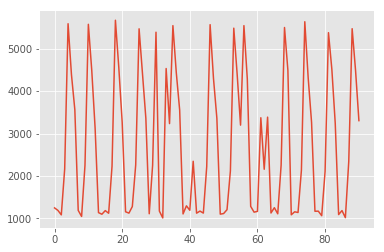

In [99]:
plt.plot(conversions)

In [103]:
np.arange(len(conversions))

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90])

In [119]:
fs = 1/(3600*24)
f, Pxx_den = signal.welch(conversions,fs,scaling='spectrum',nperseg=30)

Text(0, 0.5, 'Signal power')

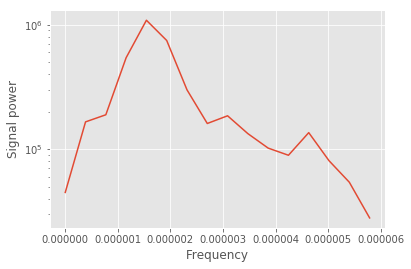

In [132]:
plt.semilogy(f,Pxx_den)
plt.xlabel('Frequency')
plt.ylabel('Signal power')

In [128]:
(1/f[np.argmax(Pxx_den)])/(3600*24)

7.5

It looks like the cycle length is about one week. This means that 2 weeks is the minumum length of time for which we can run the experiment. 